In [1]:
import pandas as pd
from datetime import date,timedelta
import statistics
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error, r2_score
import datetime as dt
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.arima_model import ARIMA
import numpy as np
import matplotlib.pyplot as plt
from sklearn import linear_model
from sklearn import svm
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 20,15
import seaborn as sns

In [2]:
# params
# TODO: fit 01 best order 3,1,3
# TODO: fit 03 best order 10,1,10
windownr = '3'
win = 3
useridnr = 'AS14.03'
customorder = 3,1,3

In [3]:
#df = pd.read_csv("E:/users/KMN14/Personal/DMT/dataset_mood_smartphone.csv", usecols=['id', 'time','variable','value'])
df = df = pd.read_csv("C:/Users/maga0002/OneDrive - HZ University of Applied Sciences/Master/Courses/DMT/Assignment 1/dataset_mood_smartphone.csv", usecols=['id', 'time','variable','value'])

In [4]:
df['time'] = pd.to_datetime(df['time'])

In [5]:
df['time'] = pd.to_datetime(df.time).dt.date

In [6]:
df.tail()

,id,time,variable,value
376907,AS14.30,2014-04-11,appCat.weather,8.032
376908,AS14.30,2014-04-19,appCat.weather,3.008
376909,AS14.30,2014-04-26,appCat.weather,7.026
376910,AS14.30,2014-04-27,appCat.weather,23.033
376911,AS14.32,2014-04-07,appCat.weather,22.431


<ipython-input-7-f66d9d55ed3b>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mood_df_exp['time'] = pd.to_datetime(mood_df_exp.time).dt.date


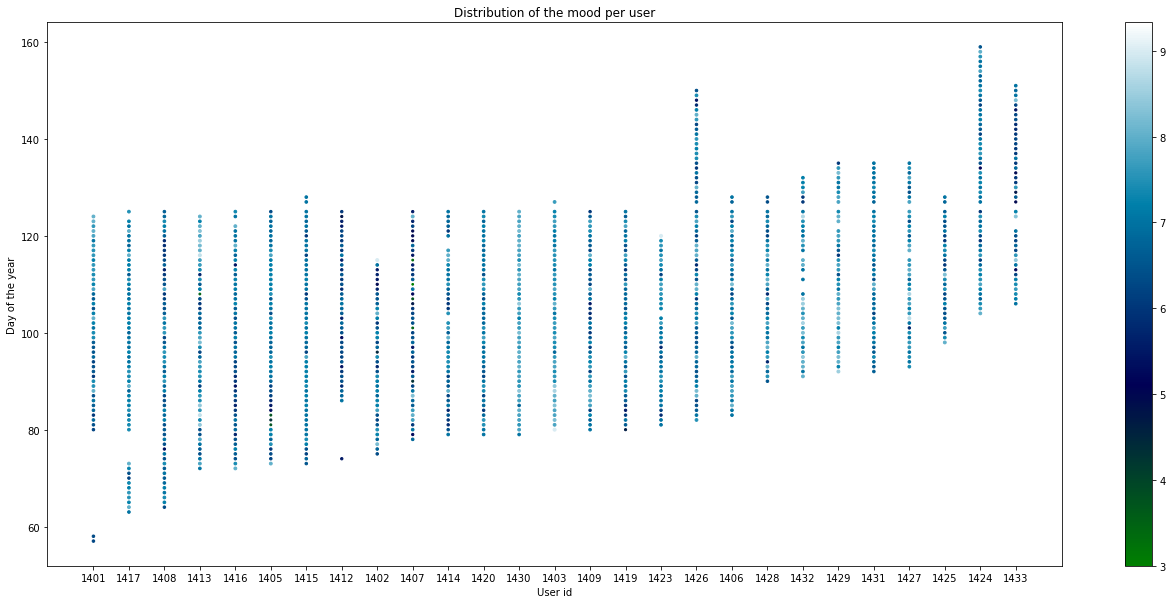

In [7]:
#Exploratory analysis to see how the mood values are distributed per user
mood_df_exp = df[df['variable'] == 'mood']
mood_df_exp['time'] = pd.to_datetime(mood_df_exp.time).dt.date
mood_df_fmt = mood_df_exp.groupby(['time', 'id']).mean().reset_index()
mood_df_fmt['id'] = mood_df_fmt['id'].str.replace(r'\D', '')
mood_df_fmt['time'] =  pd.to_datetime(mood_df_fmt['time'])
mood_df_fmt['dayofyear'] = mood_df_fmt['time'].dt.dayofyear
fig = plt.figure(figsize=(50,10))
ax1 = plt.subplot(121)
sc = plt.scatter(mood_df_fmt['id'], mood_df_fmt['dayofyear'], mood_df_fmt['value'], c=mood_df_fmt['value'] , cmap='ocean')
cbar = fig.colorbar(sc, orientation='vertical')    
plt.xlabel('User id')
plt.ylabel('Day of the year')
plt.title('Distribution of the mood per user')
plt.savefig('Mood_distribution_all_users.pdf')

In [8]:
## add period value
def process_period(date):
    new_date = date - timedelta(5)
    return str(new_date) + ' till ' + str(date)

In [9]:
df['period'] = df['time'].apply(process_period)

In [10]:
df.sort_values(['id', 'time', 'variable'], ascending=[True,True,True],inplace=True)

In [11]:
# Run process for each iteration -> each iteration Windows = tdays
# Process for mood 
mood_df = df[df['variable'] == 'mood']
mood_grouped = mood_df.groupby(['id', 'time', 'variable']).mean().reset_index()
date_values = df['time'].iloc[-1]
for i in range (0,10):
    upd_date_value = date_values + timedelta(i)
    for i in range (1, 34):
        if i <=9:
            id_value = str('AS14.') + '0' + str(i)
        else:
            id_value = str('AS14.') +  str(i)
        mood_grouped = mood_grouped.append({'id' : id_value,
                        'time' : upd_date_value, 'variable' : 'mood', 'value': 0.0} , 
                        ignore_index=True)
df = pd.merge(left = df, right = mood_grouped, how = 'left', left_on = ['id', 'time'], right_on = ['id', 'time'])
df.rename(columns ={'value_x': 'value', 'value_y': 'mood', 'variable_x': 'variable'}, inplace=True)
del df['variable_y']

#Process for activity
activity_df = df[df['variable'] == 'activity']
del activity_df['mood']
del activity_df['period']
activity_grouped = activity_df.groupby(['id', 'time', 'variable']).mean().reset_index()
date_values = activity_df['time'].iloc[-1]
for i in range (0,11):
    upd_date_value = date_values + timedelta(i)
    for i in range (1, 34):
        if i <=9:
            id_value = str('AS14.') + '0' + str(i)
        else:
            id_value = str('AS14.') +  str(i)
        activity_grouped = activity_grouped.append({'id' : id_value,
                    'time' : upd_date_value, 'variable' : 'activity', 'value': 0.0} , 
                    ignore_index=True)
activity_grouped['time'] = pd.to_datetime(activity_grouped.time)
df['time'] = pd.to_datetime(df.time)
grouped_activity = activity_grouped.groupby('id').apply(lambda x: x.set_index('time').resample('1D').first())
df_activity = grouped_activity.groupby(level=0)['value'].apply(lambda x: x.shift().rolling(min_periods=1,window=win).mean()).reset_index(name='Value_Average_Past_5_days')
df_activity['variable'] = 'activity'
df = pd.merge(left = df, right = df_activity, how = 'left', left_on = ['id', 'time'], right_on = ['id', 'time'])
df.rename(columns ={'Value_Average_Past_5_days': 'activity', 'variable_x': 'variable'}, inplace=True)
del df['variable_y']

#Process for arousal
arousal_df = df[df['variable'] == 'circumplex.arousal']
del arousal_df['mood']
del arousal_df['period']
del arousal_df['activity']
arousal_grouped = arousal_df.groupby(['id', 'time', 'variable']).mean().reset_index()
date_values = arousal_df['time'].iloc[-1]
for i in range (0,11):
    upd_date_value = date_values + timedelta(i)
    for i in range (1, 34):
        if i <=9:
            id_value = str('AS14.') + '0' + str(i)
        else:
            id_value = str('AS14.') +  str(i)
        arousal_grouped = arousal_grouped.append({'id' : id_value,
                    'time' : upd_date_value, 'variable' : 'arousal', 'value': 0.0} , 
                    ignore_index=True)
arousal_grouped['time'] = pd.to_datetime(arousal_grouped.time)
df['time'] = pd.to_datetime(df.time)
grouped_arousal = arousal_grouped.groupby('id').apply(lambda x: x.set_index('time').resample('1D').first())
df_arousal = grouped_arousal.groupby(level=0)['value'].apply(lambda x: x.shift().rolling(min_periods=1,window=win).mean()).reset_index(name='Value_Average_Past_5_days')
df_arousal['variable'] = 'arousal'
df = pd.merge(left = df, right = df_arousal, how = 'left', left_on = ['id', 'time'], right_on = ['id', 'time'])
df.rename(columns ={'Value_Average_Past_5_days': 'arousal', 'variable_x': 'variable'}, inplace=True)
del df['variable_y']

#Process for valence
valence_df = df[df['variable'] == 'circumplex.valence']
del valence_df['mood']
del valence_df['period']
del valence_df['activity']
del valence_df['arousal']
valence_grouped = valence_df.groupby(['id', 'time', 'variable']).mean().reset_index()
date_values = valence_df['time'].iloc[-1]
for i in range (0,11):
    upd_date_value = date_values + timedelta(i)
    for i in range (1, 34):
        if i <=9:
            id_value = str('AS14.') + '0' + str(i)
        else:
            id_value = str('AS14.') +  str(i)
        valence_grouped = valence_grouped.append({'id' : id_value,
                    'time' : upd_date_value, 'variable' : 'valence', 'value': 0.0} , 
                    ignore_index=True)
valence_grouped['time'] = pd.to_datetime(valence_grouped.time)
df['time'] = pd.to_datetime(df.time)
grouped_valence = valence_grouped.groupby('id').apply(lambda x: x.set_index('time').resample('1D').first())
df_valence = grouped_valence.groupby(level=0)['value'].apply(lambda x: x.shift().rolling(min_periods=1,window=win).mean()).reset_index(name='Value_Average_Past_5_days')
df_valence['variable'] = 'valence'
df = pd.merge(left = df, right = df_valence, how = 'left', left_on = ['id', 'time'], right_on = ['id', 'time'])
df.rename(columns ={'Value_Average_Past_5_days': 'valence', 'variable_x': 'variable'}, inplace=True)
del df['variable_y']

#Process for screen
screen_df = df[df['variable'] == 'screen']
del screen_df['mood']
del screen_df['activity']
del screen_df['arousal']
del screen_df['valence']
del screen_df['period']
screen_grouped = screen_df.groupby(['id', 'time', 'variable']).mean().reset_index()
date_values = screen_grouped['time'].iloc[-1]
for i in range (0,11):
    upd_date_value = date_values + timedelta(i)
    for i in range (1, 34):
        if i <=9:
            id_value = str('AS14.') + '0' + str(i)
        else:
            id_value = str('AS14.') +  str(i)
        screen_grouped = screen_grouped.append({'id' : id_value,
                    'time' : upd_date_value, 'variable' : 'screen', 'value': 0.0} , 
                    ignore_index=True)
screen_grouped['time'] = pd.to_datetime(screen_grouped.time)
grouped_screen = screen_grouped.groupby('id').apply(lambda x: x.set_index('time').resample('1D').first())
df_screen = grouped_screen.groupby(level=0)['value'].apply(lambda x: x.shift().rolling(min_periods=1,window=win).mean()).reset_index(name='Value_Average_Past_5_days')
df_screen['variable'] = 'screen'
df = pd.merge(left = df, right = df_screen, how = 'left', left_on = ['id', 'time'], right_on = ['id', 'time'])
df.rename(columns ={'Value_Average_Past_5_days': 'screen', 'variable_x': 'variable'}, inplace=True)
del df['variable_y']

#Process for call
call_df = df[df['variable'] == 'call']
del call_df['mood']
del call_df['activity']
del call_df['screen']
del call_df['arousal']
del call_df['valence']
del call_df['period']
call_grouped = call_df.groupby(['id', 'time', 'variable']).sum().reset_index()
date_values = call_grouped['time'].iloc[-1]
for i in range (0,11):
    upd_date_value = date_values + timedelta(i)
    for i in range (1, 34):
        if i <=9:
            id_value = str('AS14.') + '0' + str(i)
        else:
            id_value = str('AS14.') +  str(i)
        call_grouped = call_grouped.append({'id' : id_value,
                    'time' : upd_date_value, 'variable' : 'call', 'value': 0.0} , 
                    ignore_index=True)
call_grouped['time'] = pd.to_datetime(call_grouped.time)
grouped_call = call_grouped.groupby('id').apply(lambda x: x.set_index('time').resample('1D').first())
df_call = grouped_call.groupby(level=0)['value'].apply(lambda x: x.shift().rolling(min_periods=1,window=win).sum()).reset_index(name='Value_Average_Past_5_days')
df_call['variable'] = 'call'
df = pd.merge(left = df, right = df_call, how = 'left', left_on = ['id', 'time'], right_on = ['id', 'time'])
df.rename(columns ={'Value_Average_Past_5_days': 'call', 'variable_x': 'variable'}, inplace=True)
del df['variable_y']

#Process for sms
sms_df = df[df['variable'] == 'sms']
del sms_df['mood']
del sms_df['activity']
del sms_df['screen']
del sms_df['call']
del sms_df['arousal']
del sms_df['valence']
del sms_df['period']
sms_grouped = sms_df.groupby(['id', 'time', 'variable']).sum().reset_index()
date_values = sms_grouped['time'].iloc[-1]
for i in range (0,11):
    upd_date_value = date_values + timedelta(i)
    for i in range (1, 34):
        if i <=9:
            id_value = str('AS14.') + '0' + str(i)
        else:
            id_value = str('AS14.') +  str(i)
        sms_grouped = sms_grouped.append({'id' : id_value,
                    'time' : upd_date_value, 'variable' : 'sms', 'value': 0.0} , 
                    ignore_index=True)
sms_grouped['time'] = pd.to_datetime(sms_grouped.time)
grouped_sms = sms_grouped.groupby('id').apply(lambda x: x.set_index('time').resample('1D').first())
df_sms = grouped_sms.groupby(level=0)['value'].apply(lambda x: x.shift().rolling(min_periods=1,window=win).sum()).reset_index(name='Value_Average_Past_5_days')
df_sms['variable'] = 'sms'
df = pd.merge(left = df, right = df_sms, how = 'left', left_on = ['id', 'time'], right_on = ['id', 'time'])
df.rename(columns ={'Value_Average_Past_5_days': 'sms', 'variable_x': 'variable'}, inplace=True)
del df['variable_y']

# Process for #appcat
appcat_df = df[df['variable'].str.contains("appCat")]
del appcat_df['mood']
del appcat_df['activity']
del appcat_df['screen']
del appcat_df['call']
del appcat_df['sms']
del appcat_df['value']
del appcat_df['arousal']
del appcat_df['valence']
del appcat_df['period']
appcat_grouped = appcat_df.groupby(['id', 'time','variable']).count().reset_index()
df_test = pd.DataFrame()
df_test['count'] = appcat_grouped.groupby(['id', 'time'])['variable'].nunique()
app_cat_fmt = pd.merge(left = appcat_grouped, right = df_test, how = 'left', left_on = ['id', 'time'], right_on = ['id', 'time'])
app_cat_fmt.drop_duplicates(['id','time'],keep= 'first')
date_values = app_cat_fmt['time'].iloc[-1]
for i in range (0,11):
    upd_date_value = date_values + timedelta(i)
    for i in range (1, 34):
        if i <=9:
            id_value = str('AS14.') + '0' + str(i)
        else:
            id_value = str('AS14.') +  str(i)
        app_cat_fmt = app_cat_fmt.append({'id' : id_value,
                    'time' : upd_date_value, 'variable' : 'appCat', 'value': 0.0} , 
                    ignore_index=True)
app_cat_fmt['time'] = pd.to_datetime(app_cat_fmt.time)
grouped_appcat = app_cat_fmt.groupby('id').apply(lambda x: x.set_index('time').resample('1D').first())
df_appcat = grouped_appcat.groupby(level=0)['count'].apply(lambda x: x.shift().rolling(min_periods=1,window=win).sum()).reset_index(name='Value_Average_Past_5_days')
df_appcat['variable'] = 'appCat'
df_appcat.rename(columns ={'Value_Average_Past_5_days': '#appcat'}, inplace=True)
appCat_duration_df = df[df['variable'].str.contains("appCat")]
del appCat_duration_df['mood']
del appCat_duration_df['activity']
del appCat_duration_df['screen']
del appCat_duration_df['call']
del appCat_duration_df['sms']
del appCat_duration_df['arousal']
del appCat_duration_df['valence']
del appCat_duration_df['period']

#Process for appCat duration
#appCat_duration_df['variable'] = appCat_duration_df['variable'].replace(['circumplex.valence'], 'circumplexvalence')
#appCat_duration_df['variable'] = appCat_duration_df['variable'].replace(['circumplex.arousal'], 'circumplexarousal')
appCat_duration_df['variable'] = appCat_duration_df['variable'].str.replace(r'[.].*', '')
appCat_duration_grouped = appCat_duration_df.groupby(['id', 'time', 'variable']).mean().reset_index()
date_values = appCat_duration_grouped['time'].iloc[-1]
for i in range (0,11):
    upd_date_value = date_values + timedelta(i)
    for i in range (1, 34):
        if i <=9:
            id_value = str('AS14.') + '0' + str(i)
        else:
            id_value = str('AS14.') +  str(i)
        appCat_duration_grouped = appCat_duration_grouped.append({'id' : id_value,
                    'time' : upd_date_value, 'variable' : 'appCat', 'value': 0.0} , 
                    ignore_index=True)
appCat_duration_grouped['time'] = pd.to_datetime(appCat_duration_grouped.time)
grouped_appCat_duration = appCat_duration_grouped.groupby('id').apply(lambda x: x.set_index('time').resample('1D').first())
df_appCat_duration = grouped_appCat_duration.groupby(level=0)['value'].apply(lambda x: x.shift().rolling(min_periods=1,window=win).mean()).reset_index(name='Value_Average_Past_5_days')
df_appCat_duration.rename(columns ={'Value_Average_Past_5_days': 'appCat_duration', 'variable_x': 'variable'}, inplace=True)
df_appCat_duration['variable'] = 'appCat'
df['variable'] = df['variable'].str.rsplit('.', n=1).str.get(0)
df = pd.merge(left = df, right = df_appcat, how = 'left', left_on = ['id', 'time'], right_on = ['id', 'time'])
df.rename(columns ={'variable_x': 'variable'}, inplace=True)
del df['variable_y']
df = pd.merge(left = df, right = df_appCat_duration, how = 'left', left_on = ['id', 'time'], right_on = ['id', 'time'])
df.rename(columns ={'variable_x': 'variable'}, inplace=True)
del df['variable_y']
test_df = df.copy()
test_df = test_df.groupby(['id','period'],as_index=False).first()
del test_df['variable']
   # return test_df


<ipython-input-11-1d8666dedd6b>:227: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  appCat_duration_df['variable'] = appCat_duration_df['variable'].str.replace(r'[.].*', '')


In [12]:
def calc_vif(X):

    # Calculating VIF
    vif = pd.DataFrame()
    vif["variables"] = X.columns
    vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

    return(vif)

In [13]:
# Multi collinearity test 
test_multi_collinearity = test_df.copy()
del test_multi_collinearity['id']
del test_multi_collinearity['mood']
del test_multi_collinearity['time']
del test_multi_collinearity['period']
test_multi_collinearity.dropna(inplace=True)
X = test_multi_collinearity.iloc[:,:]
calc_vif(X)

,variables,VIF
0,value,1.300838
1,activity,3.932604
2,arousal,1.181365
3,valence,4.938057
4,screen,3.732373
5,call,2.141090
6,sms,1.900595
7,#appcat,7.796863
8,appCat_duration,2.732857


In [14]:
df = test_df.copy()

In [15]:
from scipy.optimize import curve_fit
userids = list(df.id.unique())
scope = ['AS14.01', 'AS14.03']   # used person id's in the research
#scope = userids

In [ ]:
nan_cols = [i for i in df.columns if df[i].isnull().any()]

In [ ]:
# extropolate - linear
def func(x, a, b, c, d):
    return a + b  + c * x + d

In [ ]:
guess = (0.5, 0.5, 0.5, 0.5)

In [ ]:
# Create copy of data to remove NaNs for curve fitting
fit_df = df.dropna()
# Place to store function parameters for each column
col_params = {}

In [ ]:
# Reg = used person id (just pointing 1 as a starter for later function)
reg='AS14.01'

In [ ]:
reg_fit_df = fit_df[fit_df['id']==reg]

In [ ]:
# Curve fit each column
for reg in scope: 
    reg_fit_df = fit_df[fit_df['id']==reg]
    for col in nan_cols:  
        # Get x & y
        x = reg_fit_df.index.astype(float).values
        y = reg_fit_df[col].values
        # Curve fit column and get curve parameters
        params = curve_fit(func, x, y, guess)
        # Store optimized parameters
        col_params[reg+col] = params[0]

In [ ]:
# # Extrapolate each column
for reg in scope:
    for col in nan_cols:
        # Get the index values for NaNs in the column
        x = df[df['id']==reg][pd.isnull(df[col])].index.astype(float).values       
        # Extrapolate those points with the fitted function
        df[col][x] = func(x, *col_params[reg + col])

In [ ]:
del df['period']
df['time'] = pd.to_datetime(df['time'])
df['time']=df['time'].map(dt.datetime.toordinal)

In [ ]:
df.head()

In [ ]:
# Select only rows corresponding to AS14.01 
# TODO repeat each window for each user (so 01 & 03)
AS14_df = df[df['id'] == useridnr]

In [ ]:
AS14_df.sort_values('time',inplace=True)

In [ ]:
#Split dataset into train, validation and test
X = AS14_df.drop(['mood','id'],axis=1)
Y = AS14_df['mood']
x_train = X.iloc[0:49]
y_train = Y.iloc[0:49]
x_val = X.iloc[50:59]
y_val = Y.iloc[50:59]
x_test = X.iloc[60:72]
y_test = Y.iloc[60:72]

In [ ]:
#Decision Tree Regressor
dr = DecisionTreeRegressor(random_state=300).fit(x_train,y_train)
print(dr.score(x_train,y_train))
print(mean_squared_error(y_train, dr.predict(x_train)))
print(dr.score(x_val,y_val))
print(mean_squared_error(y_val, dr.predict(x_val)))
print(dr.score(x_test,y_test))
print(mean_squared_error(y_test, dr.predict(x_test)))

In [ ]:
#Random Forest Regressor
rf = RandomForestRegressor(max_depth=100, random_state=10,n_estimators = 200).fit(x_train,y_train)
print(rf.score(x_train,y_train))
print(mean_squared_error(y_train, rf.predict(x_train)))
print(rf.score(x_val,y_val))
print(mean_squared_error(y_val, rf.predict(x_val)))
print(rf.score(x_test,y_test))
print(mean_squared_error(y_test, rf.predict(x_test)))

In [ ]:
#Linear ridge regression
reg = linear_model.Ridge(alpha=2.0)
reg.fit(x_train,y_train)
print(reg.score(x_train,y_train))
print(mean_squared_error(y_train, reg.predict(x_train)))
print(reg.score(x_val,y_val))
print(mean_squared_error(y_val, reg.predict(x_val)))
print(reg.score(x_test,y_test))
print(mean_squared_error(y_test, reg.predict(x_test)))

In [ ]:
# SVM Regressor
regr = svm.SVR(kernel='rbf', C=100, gamma=0.5, epsilon=0.1)
regr.fit(x_train, y_train)
print(regr.score(x_train,y_train))
print(mean_squared_error(y_train, regr.predict(x_train)))
print(regr.score(x_val,y_val))
print(mean_squared_error(y_val, regr.predict(x_val)))
print(regr.score(x_test,y_test))
print(mean_squared_error(y_test, regr.predict(x_test)))

In [ ]:
#Linear Regression
lr = LinearRegression()
lr.fit(x_train,y_train)
print(lr.score(x_train,y_train))
print(mean_squared_error(y_train, lr.predict(x_train)))
print(lr.score(x_val,y_val))
print(mean_squared_error(y_val, lr.predict(x_val)))
print(lr.score(x_test,y_test))
print(mean_squared_error(y_test, lr.predict(x_test)))

In [ ]:
importance = dr.feature_importances_
plt.subplot(2,2,1)
plt.bar([x for x in range(len(importance))], importance)
plt.xlabel('Features')
plt.ylabel('Feature Importance')
plt.title(useridnr+ ': Feature importance for Decision tree model with '+windownr+' past days of data')
importance = rf.feature_importances_
plt.subplot(2,2,2)
plt.bar([x for x in range(len(importance))], importance)
plt.xlabel('Features')
plt.ylabel('Feature Importance')
plt.title(useridnr+ ': Feature importance for Random forest model with '+windownr+' past days of data')
importance = lr.coef_
plt.subplot(2,2,3)
plt.bar([x for x in range(len(importance))], importance)
plt.xlabel('Features')
plt.ylabel('Feature Importance')
plt.title(useridnr+ ': Feature importance for Linear regression model with '+windownr+' past days of data')
plt.savefig(useridnr+ '_'+windownr+'_feature_importance.pdf')

In [ ]:
#Mean Model

def determine_mean_mood(date_values):
    previous_date = date_values - timedelta(1)
#    print('current_date',date_values)
#    print('previous-date', previous_date)
    #print(combined_df.loc[combined_df['time'] == previous_date, 'original_mood'])
    return combined_df.loc[combined_df['time'] == previous_date, 'original_mood']
    #return combined_df.query('time==3')['A']

In [ ]:
def append_predict_values(model_name, model_code, combined_df):
    Y_df_train = pd.DataFrame()
    Y_df_val = pd.DataFrame()
    Y_df_test = pd.DataFrame()
    Y_df = pd.DataFrame()
    Y_df_train[model_name] = model_code.predict(x_train)
    Y_df_val[model_name] = model_code.predict(x_val)
    Y_df_test[model_name] = model_code.predict(x_test)
    Y_df = pd.concat((Y_df_train, Y_df_val, Y_df_test))
    combined_df = combined_df.reset_index(drop=True)
    Y_df = Y_df.reset_index(drop=True)
    combined_df[model_name] = Y_df[model_name]
    return combined_df

In [ ]:
# consolidate results
combined_x_df = pd.concat((x_train, x_val, x_test))
combined_y_df = pd.concat((y_train, y_val, y_test))
combined_df = pd.concat((combined_x_df,combined_y_df),axis=1)
combined_df['id'] = useridnr
combined_df.rename(columns ={'mood': 'original_mood'}, inplace=True)
combined_df = append_predict_values('linear_model',lr,combined_df)
combined_df = append_predict_values('random_forest',rf,combined_df)
combined_df = append_predict_values('decision_tree',dr,combined_df)
combined_df = append_predict_values('svm',regr,combined_df)
combined_df.sort_values('time',inplace=True)
combined_df['time'] = combined_df['time'].apply(dt.datetime.fromordinal)

In [ ]:
run_diffs_apply = combined_df.apply(
         lambda row: determine_mean_mood(row['time']),
         axis=1)
#print(run_diffs_apply)
run = pd.DataFrame(run_diffs_apply)
run['team_token'] = 'a'
run_fmt = run.groupby('team_token').max().reset_index()
del run_fmt['team_token']
run_transpose = run_fmt.T
#line = pd.DataFrame({0: 0}, index=[0])
#df2 = pd.concat([line,run_transpose.ix[:]]).reset_index(drop=True)
#df3 = df2.shift()
df2 = run_transpose.shift()
combined_df['benchmark'] = 0
combined_df['benchmark'] = df2
final_mood = combined_df.iloc[[-2]]['original_mood'].values
combined_df.benchmark.iloc[[-1]]= final_mood[0]

In [ ]:
def plot_graphs(combined_df,model_name,res_sum):
    indexed_combined_df = combined_df.set_index(['time'])
    #del indexed_combined_df['id']
    #variables_to_remove = ['value','activity','screen','call','sms','#appcat','appCat_duration','id']
    indexed_combined_df_lr = indexed_combined_df[['original_mood', model_name]]
    import matplotlib.pyplot as plt
    from matplotlib.pylab import rcParams
    rcParams['figure.figsize'] = 20,15
    plt.plot(indexed_combined_df_lr)
    plt.legend(['original_mood',model_name],loc='upper left')
    plt.title('RSS: %4f'%res_sum)
    plt.show()

In [ ]:
#ARIMA Model
x_train['time'] = x_train['time'].apply(dt.datetime.fromordinal)
combined_train_df = pd.concat((x_train,y_train), axis=1)
indexed_x_train_df = combined_train_df.set_index(['time'])
variables_to_remove = ['value','activity','screen','call','sms','#appcat','appCat_duration', 'valence', 'arousal']
indexed_x_train_df.drop(variables_to_remove,axis=1,inplace=True)
rolmean = indexed_x_train_df.rolling(window=2).mean()
rolstd = indexed_x_train_df.rolling(window=2).std()
#print(rolmean, rolstd)

In [ ]:
orig = plt.plot(indexed_x_train_df,color='blue',label='Original')
mean = plt.plot(rolmean, color='red', label='Rolling Mean')
std = plt.plot(rolstd, color='black', label='Rolling Standard deviation')
plt.legend(loc='best')
plt.title('Rolling Mean & Standard Deviation')
plt.show(block=False)

In [ ]:
#Dicky Fullerer test
#H0: Non-stationary
#H1: Stationary
dftest = adfuller(indexed_x_train_df['mood'], autolag = 'AIC')
dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags used', '#of observations used'])
for key, value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value

print(dfoutput)

In [ ]:
x_train_shift = indexed_x_train_df - indexed_x_train_df.shift()
plt.plot(x_train_shift)
x_train_shift.dropna(inplace=True)

In [ ]:
orig = plt.plot(x_train_shift, color='blue', label='Original')
mean = plt.plot(rolmean, color='red', label='Rolling Mean')
std = plt.plot(rolstd, color='black', label='Rolling Std')
plt.legend(loc='best')
plt.title('Rolling Mean & Standard Deviation')
plt.show(block=False)

In [ ]:
dftest = adfuller(x_train_shift['mood'], autolag = 'AIC')
dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags used', '#of observations used'])
for key, value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value

print(dfoutput)

In [ ]:
#ACF and PACF plots:

lag_acf = acf(x_train_shift, nlags=20)
lag_pacf = pacf(x_train_shift, nlags=20, method = 'ols')

#Plot ACF:

plt.subplot(121)
plt.plot(lag_acf)
plt.axhline(y=0, linestyle='--', color='gray')
plt.axhline(y=-1.96/np.sqrt(len(x_train_shift)), linestyle='--', color='gray')
plt.axhline(y=1.96/np.sqrt(len(x_train_shift)), linestyle='--', color='gray')
plt.title('Autocorrelation Function')

#Plot PACF:


plt.subplot(122)
plt.plot(lag_pacf)
plt.axhline(y=0, linestyle='--', color='gray')
plt.axhline(y=-1.96/np.sqrt(len(x_train_shift)), linestyle='--', color='gray')
plt.axhline(y=1.96/np.sqrt(len(x_train_shift)), linestyle='--', color='gray')
plt.title('Partial Autocorrelation Function')
plt.tight_layout()

In [ ]:
#AR model 
# TODO: fit 01 best order 3,1,3
# TODO: fit 03 best order 10,1,10

model = ARIMA(indexed_x_train_df, order=(customorder))
results_AR = model.fit(disp=-1)
plt.plot(x_train_shift)
plt.plot(results_AR.fittedvalues, color='red')
plt.title('RSS: %.4f'% sum((results_AR.fittedvalues-x_train_shift['mood'])**2))
print('plotting AR model')

In [ ]:
#MA model
# TODO: fit 01 best order 3,1,3
# TODO: fit 03 best order 10,1,10

model = ARIMA(indexed_x_train_df, order=(3,1,3))
results_MA = model.fit(disp=-1)
plt.plot(x_train_shift)
plt.plot(results_AR.fittedvalues, color='red')
plt.title('RSS: %.4f'% sum((results_MA.fittedvalues-x_train_shift['mood'])**2))
print('plotting MA model')

In [ ]:
# TODO: fit 01 best order 3,1,3
# TODO: fit 03 best order 10,1,10

model = ARIMA(indexed_x_train_df, order=(3,1,3))
results_ARIMA = model.fit(disp=-1)
plt.plot(x_train_shift)
plt.plot(results_ARIMA.fittedvalues, color='red')
plt.title('RSS: %.4f'% sum((results_ARIMA.fittedvalues-x_train_shift['mood'])**2))
print('plotting ARIMA model')

In [ ]:
predictions_ARIMA_diff = pd.Series(results_ARIMA.fittedvalues, copy=True)
print(predictions_ARIMA_diff.head())

In [ ]:
predictions_ARIMA_diff_cumsum = predictions_ARIMA_diff.cumsum()
print(predictions_ARIMA_diff_cumsum.head())

In [ ]:
predictions_ARIMA_fmt = pd.Series(indexed_x_train_df['mood'].iloc[0], index = indexed_x_train_df.index)
predictions_ARIMA_fmt = predictions_ARIMA_fmt.add(predictions_ARIMA_diff_cumsum, fill_value=0)
predictions_ARIMA_fmt.head()

In [ ]:
plt.plot(indexed_x_train_df,color='orange')
plt.plot(predictions_ARIMA_fmt,color='blue')

In [ ]:
res= results_ARIMA.forecast(steps=21)

In [ ]:
combined_val_test = pd.concat((x_val,x_test),axis=0)
combined_val_test['time'] = combined_val_test['time'].apply(dt.datetime.fromordinal)

indexed_x_test_df = combined_val_test.set_index(['time'])

In [ ]:
variables_to_remove = ['value','activity','screen','call','sms','#appcat','appCat_duration']
indexed_x_test_df.drop(variables_to_remove,axis=1,inplace=True)

In [ ]:
predictions_ARIMA_test = pd.Series(index = indexed_x_test_df.index)
predictions_ARIMA_test = predictions_ARIMA_test.add(res[0], fill_value=0)

In [ ]:
ARIMA_predictions = pd.concat((predictions_ARIMA_fmt,predictions_ARIMA_test),axis=0)
ARIMA_predictions_fmt = pd.DataFrame(ARIMA_predictions, columns = ['arima'])

In [ ]:
combined_df_test = combined_df.copy()

In [ ]:
indexed_combined_df_results = combined_df_test.set_index(['time'])

In [ ]:
indexed_combined_df_results = indexed_combined_df_results.merge(ARIMA_predictions_fmt['arima'].to_frame(), how='left',left_index=True, right_index=True)

In [ ]:
def plot_graphs(combined_df,model_name,res_sum,row,cols,num):
    indexed_combined_df = combined_df.set_index(['time'])
    #del indexed_combined_df['id']
    #variables_to_remove = ['value','activity','screen','call','sms','#appcat','appCat_duration','id']
    indexed_combined_df_lr = indexed_combined_df[['original_mood', model_name]]
    import matplotlib.pyplot as plt
    import matplotlib.patches as patches
    from matplotlib.pylab import rcParams
    rcParams['figure.figsize'] = 20,15
    plt.subplot(row,cols,num)
    plt.plot(indexed_combined_df_lr)
    plt.legend(['original_mood',model_name],loc='upper left')
    plt.title('MSE: %4f'%res_sum)
    plt.show()

In [ ]:
def plot_arima_graphs(indexed_combined_df_results, model_name ,res_sum,row,cols,num):
    indexed_combined_df_lr = indexed_combined_df_results[['original_mood', model_name]]
    import matplotlib.pyplot as plt
    from matplotlib.pylab import rcParams
    rcParams['figure.figsize'] = 20,15
    import matplotlib.patches as patches
    plt.subplot(row,cols,num)
    plt.plot(indexed_combined_df_lr.shift())
    plt.legend(['original_mood',model_name],loc='upper left')
    plt.title('MSE: %4f'%res_sum)
    plt.show()

In [ ]:
#Plot linear regression plot
res_sum = ((lr.predict(x_test) - y_test) ** 2).sum()
indexed_combined_df = combined_df.set_index(['time'])
indexed_combined_df_lr = indexed_combined_df[['original_mood', 'linear_model']]
plt.subplot(2,3,1)
plt.subplots_adjust(bottom = -0.1) 
plt.plot(indexed_combined_df_lr)
plt.legend(['original_mood','linear_model'],loc='upper left')
plt.xticks(rotation='vertical')
plt.title(useridnr+ ':Linear Regression Model,Past Days='+windownr+' , MSE: %4f'%res_sum)

res_sum = ((rf.predict(x_test) - y_test) ** 2).sum()
indexed_combined_df = combined_df.set_index(['time'])
indexed_combined_df_lr = indexed_combined_df[['original_mood', 'random_forest']]
plt.subplot(2,3,2)
plt.plot(indexed_combined_df_lr)
plt.legend(['original_mood','random_forest'],loc='upper left')
plt.xticks(rotation='vertical')
plt.title(useridnr+ ':Random Forest Model, Past Days ='+ windownr +', MSE: %4f'%res_sum)


res_sum = ((dr.predict(x_test) - y_test) ** 2).sum()
indexed_combined_df = combined_df.set_index(['time'])
indexed_combined_df_lr = indexed_combined_df[['original_mood', 'decision_tree']]
plt.subplot(2,3,3)
plt.plot(indexed_combined_df_lr)
plt.legend(['original_mood','decision_tree'],loc='upper left')
plt.xticks(rotation='vertical')
plt.title(useridnr+ ':Decision Tree Model, Past Days ='+ windownr +', MSE: %4f'%res_sum)

res_sum = ((regr.predict(x_test) - y_test) ** 2).sum()
indexed_combined_df = combined_df.set_index(['time'])
indexed_combined_df_lr = indexed_combined_df[['original_mood', 'svm']]
plt.subplot(2,3,4)
plt.plot(indexed_combined_df_lr)
plt.legend(['original_mood','svm'],loc='upper left')
plt.xticks(rotation='vertical')
plt.title(useridnr+ ':SVM Model, Past Days ='+ windownr +', MSE: %4f'%res_sum)

res_sum = ((results_ARIMA.fittedvalues-x_train_shift['mood'])**2).sum()
indexed_combined_df_lr = indexed_combined_df_results[['original_mood', 'arima']]
plt.subplot(2,3,5)
plt.plot(indexed_combined_df_lr.shift())
plt.legend(['original_mood','arima'],loc='upper left')
plt.xticks(rotation='vertical')
plt.title(useridnr+ ':Arima Model, Past Days ='+ windownr +', MSE: %4f'%res_sum)

res_sum = ((indexed_combined_df_results['benchmark'][60:72] - indexed_combined_df_results['original_mood'][60:72]) ** 2).sum()
#res_sum = ((results_ARIMA.fittedvalues-x_train_shift['mood'])**2).sum()
indexed_combined_df_lr = indexed_combined_df_results[['original_mood', 'benchmark']]
plt.subplot(2,3,6)
plt.plot(indexed_combined_df_lr.shift())
plt.legend(['original_mood','benchmark'],loc='upper left')
plt.xticks(rotation='vertical')
plt.title(useridnr+ ':Benchmark Model, Past Days ='+ windownr +', MSE: %4f'%res_sum)
#plt.show()
plt.savefig(useridnr+'_'+ windownr +'.pdf', bbox_inches='tight')